In [118]:
import os
import torch
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_filtering as depth_filtering
import custom_utils.depth_anything_interface as get_model
import numpy as np
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression

DATAFILE = "/scratchdata/stationary"
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
MODEL = get_model.get_model(DEVICE)

In [119]:
# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

In [120]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/depth/points"]):
    wait += 1
    if wait == 6:
        print(len(msg.data))
        pc_raw = np.frombuffer(msg.data, dtype=np.uint8)
        print(pc_raw)
        print(msg.fields)
        

3559808
[243  98 223 ...   0   0   0]
[name: "x"
offset: 0
datatype: 7
count: 1, name: "y"
offset: 4
datatype: 7
count: 1, name: "z"
offset: 8
datatype: 7
count: 1]


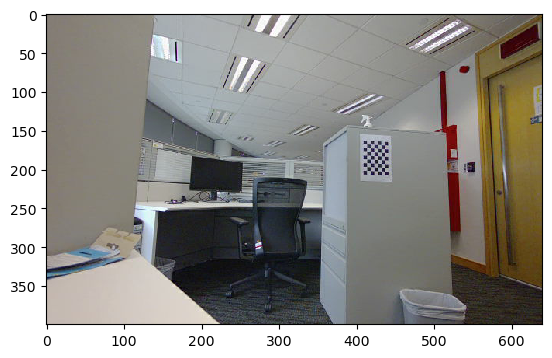

In [121]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    wait += 1
    if wait == 10:
        img = data_conversion.topic_to_image(msg)
        break

plt.imshow(img)
plt.imsave(os.path.join(DATAFILE, "color.png"), img)

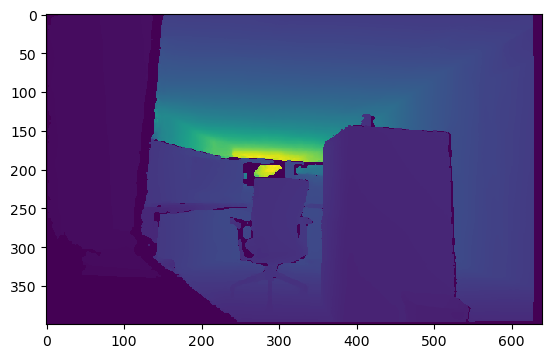

In [122]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    wait += 1
    if wait == 10:
        depth = data_conversion.topic_to_depth(msg)
        break

plt.imshow(depth)

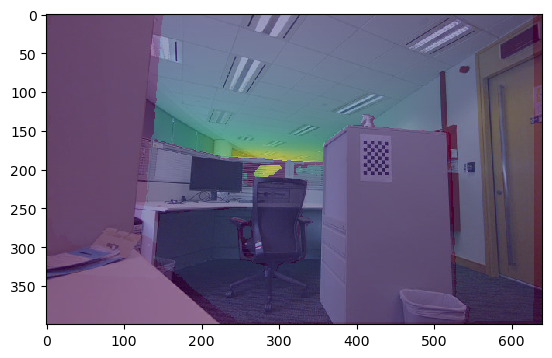

In [123]:
# Overlay image overdepth at half alpha
plt.imshow(depth)
plt.imshow(img, alpha=0.5)

/tmp/ipykernel_22978/2430795002.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(1/est_depth)


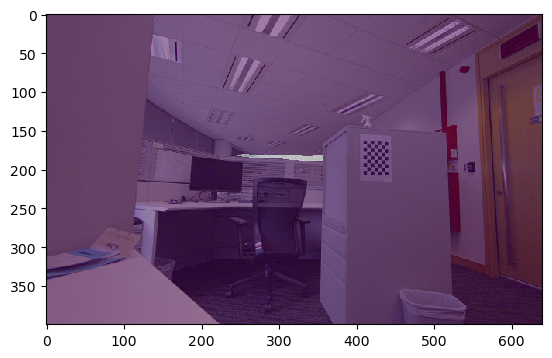

In [124]:
est_depth = MODEL.infer_image(np.array(img)) # HxW raw depth map in numpy

plt.imshow(1/est_depth)
plt.imshow(img, alpha=0.5)

R2: 0.9610662823635782


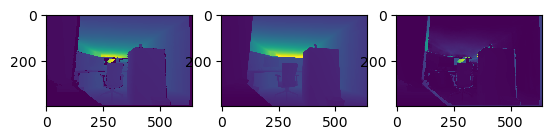

In [125]:
depth_flatten = depth.flatten()
est_depth_flatten = 1/(est_depth.flatten()+25)
est_depth_flatten = est_depth_flatten[depth_flatten!=0]
depth_flatten = depth_flatten[depth_flatten!=0]
#depth_flatten = depth_flatten[est_depth_flatten < 1]
#est_depth_flatten = est_depth_flatten[est_depth_flatten < 1]

# Calculate best fit in numpy
p = np.polyfit(est_depth_flatten, depth_flatten, 1)

pred = np.polyval(p, 1/(est_depth.flatten()+25)).reshape(depth.shape)

# Calcualte r2
r2 = np.corrcoef(est_depth_flatten, depth_flatten)[0, 1]
print(f"R2: {r2}")

fig, axs = plt.subplots(1, 3)

depth_normalised = depth_filtering.normalise(depth)
pred_normalised = depth_filtering.normalise(pred)

axs[0].imshow(depth_normalised)
axs[1].imshow(pred_normalised)
diff = abs(depth_normalised - pred_normalised)
axs[2].imshow(diff)

#plt.scatter(est_depth_flatten, depth_flatten)

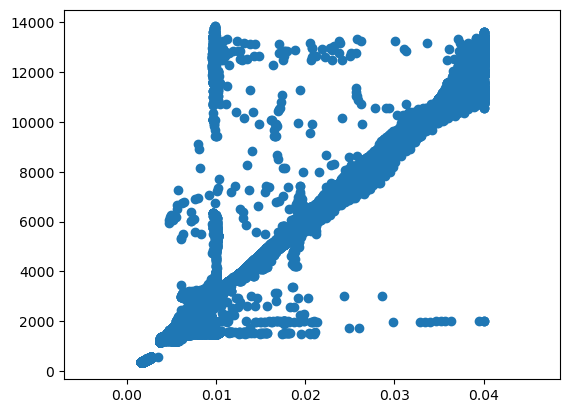

In [126]:
plt.scatter(est_depth_flatten, depth_flatten)